<a href="https://colab.research.google.com/github/Pai-Ya-Ting/Text-mining/blob/main/Information-Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Retrieval - Vector Space Model- Homework 3

## (a) Choose a query text for yourself.

In [ ]:
query = "crime thrill drama action movie"

## (b) Information Retrieval” without feature selection 

**Step 1: Read all file in "movies_synopsis" folder**


In [ ]:
# !unzip movies_synopsis.zip

In [ ]:
# this code will read all file in "movies_synopsis" folder, use nltk to tokenize and convert to lower()case
import nltk,os
nltk.download('punkt')
file_path = "movies_synopsis/"
doc_all={}

for filename in os.listdir(file_path ):
    fileExtension = filename.split(".")[-1]
    if fileExtension == "txt": # just read .txt file, in case google drive insert some hidden file which make the error.
        text = open(file_path+filename).read()
        tokens = nltk.word_tokenize(text)
        token_filtered = [w.lower() for w in tokens if w.isalpha()]
        doc_all[filename[:-4]] = token_filtered

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Step2: convert all document to vector, use tfidf weighting**

In [ ]:
# Declare all function 
# create tf function
def tf(term, token_doc):
    tf = token_doc.count(term)/len(token_doc)
    return tf

# create function to calculate how many doc contain the term 
def numDocsContaining(word, token_doclist):
    doccount = 0
    for doc_token in token_doclist:
        if doc_token.count(word) > 0:
            doccount +=1
    return doccount
  
import math
# create function to calculate  Inverse Document Frequency in doclist - this list of all documents
def idf(word, token_doclist):
    n = len(token_doclist)
    df = numDocsContaining(word, token_doclist)
    return math.log10(n/df)

#define a function to do cosine normalization a data dictionary
def cos_norm(dic): # dic is distionary data structure
    import numpy as np
    dic_norm={}
    factor=1.0/np.sqrt(sum([np.square(i) for i in dic.values()]))
    for k in dic:
        dic_norm[k] = dic[k]*factor
    return dic_norm

#create function to calculate normalize tfidf 
def compute_tfidf(token_doc,bag_words_idf):
    tfidf_doc={}
    for word in set(token_doc):
        tfidf_doc[word]= tf(word,token_doc) * bag_words_idf[word]   
    tfidf_norm = cos_norm(tfidf_doc)
    return tfidf_norm

# create normalize term frequency
def tf_norm(token_doc):
    tf_norm={}
    for term in token_doc:
        tf = token_doc.count(term)/len(token_doc)
        tf_norm[term]=tf
    tf_max = max(tf_norm.values())
    for term, value in tf_norm.items():
        tf_norm[term]= 0.5 + 0.5*value/tf_max
    return tf_norm

def compute_tfidf_query(query_token,bag_words_idf):
    tfidf_query={}
    tf_norm_query = tf_norm(query_token)
    for term, value in tf_norm_query.items():
        tfidf_query[term]=value*bag_words_idf[term]   
    return tfidf_query

In [ ]:
import os

#create bag words
bag_words =[] # declare bag_words is a list
for doc in doc_all.keys():
    bag_words += doc_all[doc]
bag_words=set(bag_words)

#calculate idf for every word in bag_words
bag_words_idf={} # declare "bag_words_idf" data structure is dictionary 
print("the number of term in bag_word", len(bag_words))
print("Start idf processing")
from tqdm.notebook import tqdm # using tqdm to show process bar
for word in tqdm(bag_words):
    bag_words_idf[word]= idf(word,doc_all.values())


##calculate tfidf with cosine normalization
tfidf={} # declare tfidf dictionary to store tfidf value
print("start tfidf processing")
for doc in tqdm(doc_all.keys()):
    tfidf[doc]= compute_tfidf(doc_all[doc],bag_words_idf)

the number of term in bag_word 23883
Start idf processing



start tfidf processing


In [ ]:
len(bag_words)

23883

**Step3: Input query text, and take similarity, if you change the query text, just need to  run the code again from here if change query text** 

{'Into the Wild (2007)': 0.018774226569654218, 'Memories of Murder (2003)': 0.017003567545757492, 'Catch Me If You Can (2002)': 0.013794138011742119, 'City of God (2002)': 0.013547716394114784, 'In the Mood for Love (2000)': 0.010591561758591994, 'Hotel Rwanda (2004)': 0.010174045738272297, 'Oldboy (2003)': 0.009659356161331512, 'Goodfellas (1990)': 0.009506874821883282, 'Monty Python_s Life of Brian (1979)': 0.008851604978115435, 'Jurassic Park (1993)': 0.008796667162047522}


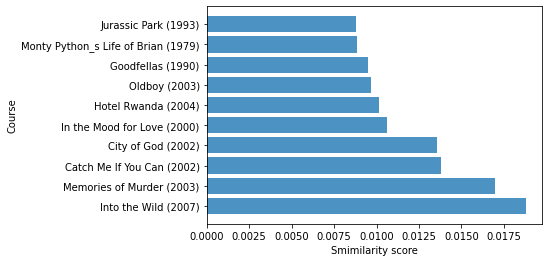

In [ ]:
# query="love romance movie"
query_token_raw= nltk.word_tokenize(query)
query_token = [term for term in query_token_raw if term in bag_words]
tfidf_query =compute_tfidf_query(query_token,bag_words_idf) #calculate tfidf for query text

# add tfidf of query text to tfidf of all doc and convert to dataframe
tfidf["query"]=tfidf_query

import pandas as pd
tfidf_df = pd.DataFrame(tfidf).transpose()
tfidf_df= tfidf_df.fillna(0) # replace all NaN by zero

from scipy.spatial.distance import cosine
cosine_sim ={}
for row in tfidf_df.index:
    if row != "query":
        cosine_sim[row]= 1-cosine(tfidf_df.loc[row],tfidf_df.loc["query"])

# the top 10 relevant document
cosine_sim_top10 = dict(sorted(cosine_sim.items(), key=lambda item: item[1],reverse=True)[:10])
print(cosine_sim_top10)

#plot barchart
import matplotlib.pyplot as plt
data = cosine_sim_top10
plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
plt.yticks(range(len(data)), list(data.keys())) # label for y axis
plt.xlabel('Smimilarity score')
plt.ylabel('Course')

# save graph
plt.savefig("barchart.png", bbox_inches='tight', dpi=600)
plt.show()

# (c) Information Retrieval” with feature selection 

**Step1: tokenization and Feature selection**

In [ ]:
import os
#Define function for feature selection (Lemmatization , POS using spacy package)
def pos_lem(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    pos_lem_tokens =[]
    for token in doc:
        if token.tag_ in ["NN"]:  # student can choose tag ["NN", "JJ", "VBG"] POS tag set in Penn Treebank project
            pos_lem_tokens+= [token.lemma_] # choose lemma text
    return pos_lem_tokens

import os, spacy
file_path = "movies_synopsis/"
doc_all_pos_lem={}

from tqdm.notebook import tqdm # show percentage of for loop
for filename in tqdm(os.listdir(file_path )):
    fileExtension = filename.split(".")[-1]
    if fileExtension == "txt": # just read .txt file, in case google drive insert some hidden file which make the error.
        text = open(file_path+filename).read()
        pos_lem_tokens = pos_lem(text)
        doc_all_pos_lem[filename[:-4]]=pos_lem_tokens

**Step2: convert all document to vector, use tfidf weighting**

In [ ]:
import os
#create bag words
bag_words_pos_lem =[] # declare bag_words is a list
for doc in doc_all_pos_lem.keys():
    bag_words_pos_lem += doc_all_pos_lem[doc]
bag_words_pos_lem=set(bag_words_pos_lem)

#calculate idf for every word in bag_words
bag_words_pos_lem_idf={} # declare "bag_words_idf" data structure is dictionary 
print("the number of term in bag_word", len(bag_words_pos_lem))
print("Start idf processing")
from tqdm.notebook import tqdm
for word in tqdm(bag_words_pos_lem):
  
  bag_words_pos_lem_idf[word]= idf(word,doc_all_pos_lem.values())


##calculate tfidf with cosine normalization
tfidf_pos_lem={} # declare tfidf dictionary to store tfidf value
print("Start tfidf processing")
for doc in tqdm(doc_all_pos_lem.keys()):
    tfidf_pos_lem[doc]= compute_tfidf(doc_all_pos_lem[doc],bag_words_pos_lem_idf)

the number of term in bag_word 7188
Start idf processing



Start tfidf processing


**Step3: Input query text, and take similarity, if you change the query text, just need to  run the code again from here if change query text** 

{'Goodfellas (1990)': 0.13980336498515955, 'City of God (2002)': 0.13498461090083635, 'In the Mood for Love (2000)': 0.12301841459392349, 'Memories of Murder (2003)': 0.11813814322686378, 'Cinema Paradiso (1988)': 0.0741026361278615, 'The Departed (2006)': 0.07383107841133396, 'The Green Mile (1999)': 0.0673280849979967, 'Casablanca (1942)': 0.06646842215042692, 'The Secret in Their Eyes (2009)': 0.0644051839017018, 'Dial M for Murder (1954)': 0.05620724694225043}


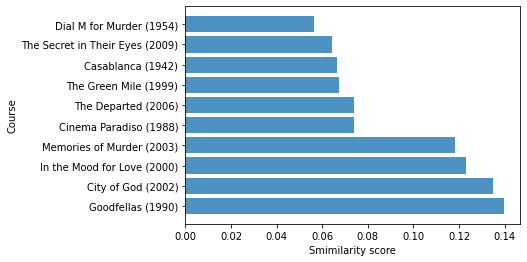

In [ ]:
query_token_raw= pos_lem(query)
query_token = [term for term in query_token_raw if term in bag_words_pos_lem]
tfidf_query =compute_tfidf_query(query_token,bag_words_pos_lem_idf) #calculate tfidf for query text

# add tfidf of query text to tfidf of all doc and convert to dataframe
tfidf_pos_lem["query"]=tfidf_query

import pandas as pd
tfidf_pos_lem_df = pd.DataFrame(tfidf_pos_lem).transpose()
tfidf_pos_lem_df= tfidf_pos_lem_df.fillna(0) # replace all NaN by zero

from scipy.spatial.distance import cosine
cosine_sim ={}
for row in tfidf_pos_lem_df.index:
    if row != "query":
        cosine_sim[row]= 1-cosine(tfidf_pos_lem_df.loc[row],tfidf_pos_lem_df.loc["query"])

# the top 10 relevant document
cosine_sim_top10 = dict(sorted(cosine_sim.items(), key=lambda item: item[1],reverse=True)[:10])
print(cosine_sim_top10)

#plot barchart
import matplotlib.pyplot as plt
data = cosine_sim_top10
plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
plt.yticks(range(len(data)), list(data.keys())) # label for y axis
plt.xlabel('Smimilarity score')
plt.ylabel('Course')

# save graph
plt.savefig("barchart.png", bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
len(bag_words_pos_lem)

7188

# (d) Compare your result in 2 cases: 

use/not use feature selection based on (1) Speed (how long the code run), the number of feature (number of terms in bag word) and the query result (the relevant movies you can extract using query text). Give your reflection about these results.

(1) Speed:

After using feature selection, the number of terms in the bag of words drops from 23883 to 7188. Therefore, the speed of calculating idf becomes a lot faster.

(2) The number of features:
After we perform feature selection, some irrevalant words would be removed. As a result, the number of terms in bag drops.

Since the terms in the bag of words is more meaningful, the similarity after feature selection improves a lot.

(3) The query result:


## **Before feature selection**

Into the Wild: Adventure, Biography, Drama

Memories of Murder: Crime, Drama, Mystery 

Catch Me If You Can: Biography, Crime, Drama 

City of God: Crime, Drama 

In the Mood for Love: Drama, Romance 

Hotel Rwanda: Biography, Drama, History 

Oldboy: Action, Drama, Mystery 

Goodfellas: Biography, Crime, Drama 

Monty python's life of Brian: Comedy

Jurassic Park: Action, Adventure, Sci-Fi 


## **After feature selection**

Goodfellas: Biography, Crime, Drama 

City of God: Crime, Drama

In the Mood for Love: Drama, Romance 

Memories of Murder: Crime, Drama, Mystery 

Cinema Paradiso: Drama, Romance 

The Departed: Crime, Drama, Thriller 

The Green Mile: Crime, Drama, Fantasy 

Casablanca: Drama, Romance, War 

The Secret in Their Eyes: Drama, Mystery, Romance 

Dial M for Murder: Crime, Thriller

**As we can see, after feature selection, the query result is more accurate than the one without feature selection.**